## Import and eval functions

In [15]:
from sympy import false
%load_ext autoreload
%autoreload 2

import sys, h5py, gc
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader

REPO_ROOT = "../"
proj = Path(REPO_ROOT).resolve()

# allow: import ADCNN.*
sys.path.insert(0, str(proj))

# allow: import utils.*  (where utils == ADCNN/utils)
sys.path.insert(0, str(proj / "ADCNN"))

from ADCNN.data.h5tiles import H5TiledDataset
from ADCNN.predict import load_model, predict_tiles_to_full

import ADCNN.evaluation as evaluation
from ADCNN.utils.utils import draw_one_line

test_h5 = "../DATA/test.h5"
test_csv = "../DATA/test.csv"
MODEL_CKPT = "../checkpoints/Best/ckpt_best.pt"
SAVE_PATH = "../checkpoints/Experiments/"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
def mark_nn_to_catalog (catalog, predictions, threshold, pixel_gap=10, psf_width=40):
    predictions = predictions >= threshold
    for image_id in catalog["image_id"].unique():
        lab, n = evaluation._label_components_fds(predictions[image_id], pixel_gap=pixel_gap)
        for i, row in catalog[catalog["image_id"]==image_id].iterrows():
            index = np.argwhere((catalog["x"] == row["x"]) & (catalog["y"] == row["y"]) & (catalog["image_id"] == row["image_id"]))[0][0]
            mask = draw_one_line(np.zeros((predictions.shape[1], predictions.shape[2]), dtype=np.uint8), [row["x"], row["y"]], row["beta"], row["trail_length"], true_value=1, line_thickness=int(psf_width/2))
            mask = mask != 0
            intersection = predictions[row["image_id"]] & mask
            lab_ids = np.unique(lab[intersection])
            lab_ids = lab_ids[lab_ids!=0]  # remove background
            lab_removed = np.isin(lab, lab_ids)
            predictions[row["image_id"]][lab_removed] = 0
            if np.any(intersection):
                catalog.at[index, "nn_detected"] = True
            else:
                catalog.at[index, "nn_detected"] = False
    return catalog

def objectwise_confusion (catalog, predictions, threshold, pixel_gap=10, psf_width=40):
    true_positive = 0
    false_negative = 0
    false_positive = 0

    predictions = predictions >= threshold
    for image_id in catalog["image_id"].unique():
        lab, n = evaluation._label_components_fds(predictions[image_id], pixel_gap=pixel_gap)
        predicted_positive = n
        for i, row in catalog[catalog["image_id"]==image_id].iterrows():
            mask = draw_one_line(np.zeros((predictions.shape[1], predictions.shape[2]), dtype=np.uint8), [row["x"], row["y"]], row["beta"], row["trail_length"], true_value=1, line_thickness=int(psf_width/2))
            mask = mask != 0
            intersection = predictions[row["image_id"]] & mask
            lab_ids = np.unique(lab[intersection])
            lab_ids = lab_ids[lab_ids!=0]  # remove background
            lab_removed = np.isin(lab, lab_ids)
            predictions[row["image_id"]][lab_removed] = 0
            if np.any(intersection):
                true_positive += 1
            else:
                false_negative += 1
        false_positive += predicted_positive - true_positive if predicted_positive - true_positive >=0 else 0
    return true_positive, false_positive, false_negative

def evaluate_model_on_catalog (catalog, predictions, ground_truth, threshold):
    catalog = catalog.copy()
    (pix_tp, pix_fp, pix_fn, pix_tn), (_, _, pix_f1, pix_f2) = evaluation.pixelwise_confusion(predictions, ground_truth, thr=threshold)
    obj_tp, obj_fp, obj_fn = objectwise_confusion(catalog, predictions, threshold=threshold, pixel_gap=2, psf_width=40)
    obj_f1 = 2*obj_tp/(2*obj_tp + obj_fp + obj_fn)
    obj_f2 = 5*obj_tp/(5*obj_tp + 4*obj_fn + obj_fp)
    catalog = mark_nn_to_catalog(catalog, predictions, threshold=threshold, pixel_gap=2, psf_width=40)
    results = {
        "pixelwise": {
            "TP": pix_tp,
            "FP": pix_fp,
            "FN": pix_fn,
            "TN": pix_tn,
            "F1": pix_f1,
            "F2": pix_f2
        },
        "objectwise": {
            "TP": obj_tp,
            "FP": obj_fp,
            "FN": obj_fn,
            "TN": -1,
            "F1": obj_f1,
            "F2": obj_f2
        }
    }
    _ = evaluation.plot_detect_hist(catalog, "PSF_mag", bins=12, title="NN detections vs PSF_mag threshold=" + str(threshold))
    _ = evaluation.plot_detect_hist(catalog, "trail_length", bins=12, title="Detections vs trail length threshold="+ str(threshold))
    print_confusion_matrix(results["pixelwise"], title=f"Pixelwise Confusion Matrix @ thr={threshold}")
    print ()
    print_confusion_matrix(results["objectwise"], title=f"Objectwise Confusion Matrix @ thr={threshold}")

    plt.show()

    return results, catalog

def print_confusion_matrix(cm, title="Confusion Matrix"):
    cm = np.array([[cm["TN"], cm["FP"]], [cm["FN"], cm["TP"]]])
    df = pd.DataFrame(cm, index=["Actual Negative", "Actual Positive"], columns=["Predicted Negative", "Predicted Positive"])
    print(title)
    print (f"F1 Score: {cm[1,1]*2/(cm[1,1]*2 + cm[0,1] + cm[1,0]):.4f}, F2 Score: {cm[1,1]*5/(cm[1,1]*5 + cm[0,1] + cm[1,0]*4):.4f}")
    print(df)

In [17]:
ds_te = H5TiledDataset(test_h5,  tile=128, k_sigma=5.0)

test_loader = DataLoader(
    ds_te,
    batch_size=128,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
    persistent_workers=False,
    prefetch_factor=None,
)

test_catalog = pd.read_csv(test_csv)
with h5py.File(test_h5, "r") as _f:
    gt_test = _f["masks"][:].astype(np.uint8)
print("Test tiles:", len(ds_te))

Test tiles: 51200


## Baseline

In [18]:
model_baseline = load_model(SAVE_PATH+"Last/Baseline.pt")
p_baseline = predict_tiles_to_full(test_h5, test_loader, model_baseline, tile=128)
model_baseline.to('cpu')
gc.collect()
torch.cuda.empty_cache()
print("Predictions shape:", p_baseline.shape)

Loaded model from: ../checkpoints/Experiments/Last/Baseline.pt
Predictions shape: (50, 4000, 4072)


Pixelwise Confusion Matrix @ thr=0.5
F1 Score: 0.4168, F2 Score: 0.4506
                 Predicted Negative  Predicted Positive
Actual Negative           812612719              799866
Actual Positive              516949              470466

Objectwise Confusion Matrix @ thr=0.5
F1 Score: 0.6469, F2 Score: 0.5823
                 Predicted Negative  Predicted Positive
Actual Negative                  -1                 139
Actual Positive                 445                 535


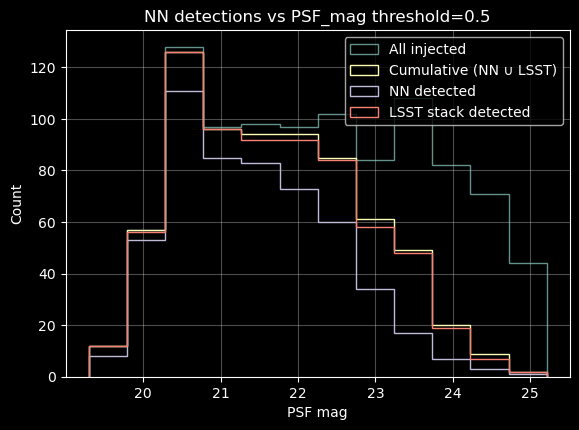

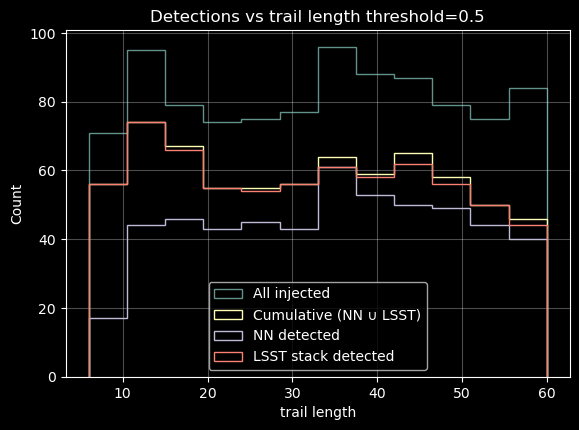

In [19]:
results_baseline, cat_baseline = evaluate_model_on_catalog(test_catalog, p_baseline, gt_test, threshold=0.5)

## Idea 1

Oversampling LSST-missed examples

In [20]:
model_1 = load_model(SAVE_PATH+"Last/idea1.pt")
p_1 = predict_tiles_to_full(test_h5, test_loader, model_1, tile=128)
model_1.to('cpu')
gc.collect()
torch.cuda.empty_cache()
print("Predictions shape:", p_1.shape)

Loaded model from: ../checkpoints/Experiments/Last/idea1.pt
Predictions shape: (50, 4000, 4072)


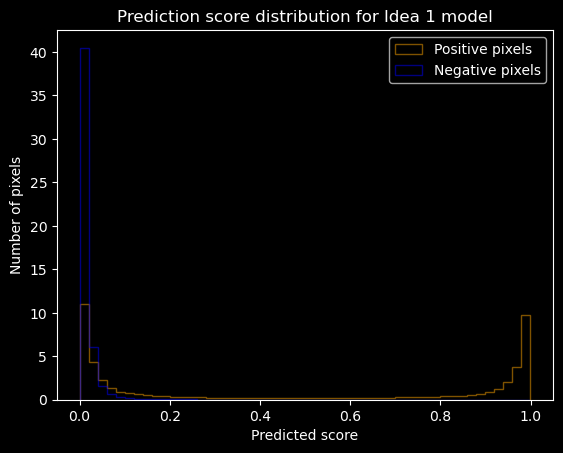

In [21]:
_ = plt.hist(p_1[gt_test>0.5].flatten(), bins=50, alpha=0.5, label="Positive pixels", histtype="step", density=True, color='orange')
_ = plt.hist(p_1[gt_test==0].flatten(), bins=50, alpha=0.5, label="Negative pixels", histtype="step", density=True, color='blue')
_ = plt.xlabel("Predicted score")
_ = plt.ylabel("Number of pixels")
_ = plt.legend()
_ = plt.title("Prediction score distribution for Idea 1 model")
plt.show()

Pixelwise Confusion Matrix @ thr=0.5
F1 Score: 0.3435, F2 Score: 0.4116
                 Predicted Negative  Predicted Positive
Actual Negative           812141440             1271145
Actual Positive              519115              468300

Objectwise Confusion Matrix @ thr=0.5
F1 Score: 0.5714, F2 Score: 0.5702
                 Predicted Negative  Predicted Positive
Actual Negative                  -1                 415
Actual Positive                 422                 558


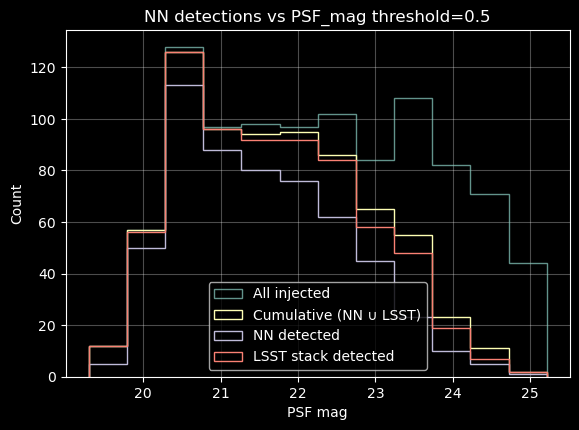

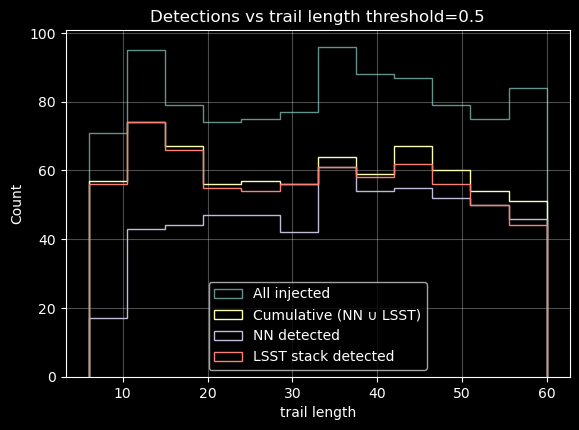

In [22]:
results_1, cat_1 = evaluate_model_on_catalog(test_catalog, p_1, gt_test, threshold=0.5)

## Idea 2

Loss biased toward LSST-missed examples. Weight the loss contribution per sample using lsst_detected: higher weight for LSST-missed, lower for LSST-detected. Optionally apply this weighting only in later epochs.

In [23]:
model_2 = load_model(SAVE_PATH+"Last/idea2.pt")
p_2 = predict_tiles_to_full(test_h5, test_loader, model_2, tile=128)
model_2.to('cpu')
gc.collect()
torch.cuda.empty_cache()
print("Predictions shape:", p_2.shape)

Loaded model from: ../checkpoints/Experiments/Last/idea2.pt
Predictions shape: (50, 4000, 4072)


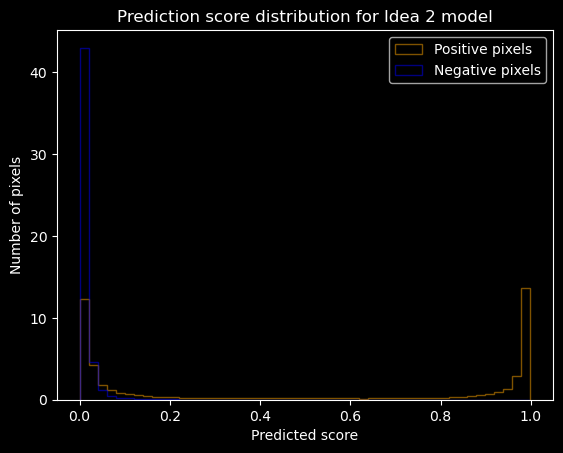

In [24]:
_ = plt.hist(p_2[gt_test>0.5].flatten(), bins=50, alpha=0.5, label="Positive pixels", histtype="step", density=True, color='orange')
_ = plt.hist(p_2[gt_test==0].flatten(), bins=50, alpha=0.5, label="Negative pixels", histtype="step", density=True, color='blue')
_ = plt.xlabel("Predicted score")
_ = plt.ylabel("Number of pixels")
_ = plt.legend()
_ = plt.title("Prediction score distribution for Idea 2 model")
plt.show()

Pixelwise Confusion Matrix @ thr=0.5
F1 Score: 0.3765, F2 Score: 0.4367
                 Predicted Negative  Predicted Positive
Actual Negative           812318757             1093828
Actual Positive              504782              482633

Objectwise Confusion Matrix @ thr=0.5
F1 Score: 0.6157, F2 Score: 0.5858
                 Predicted Negative  Predicted Positive
Actual Negative                  -1                 270
Actual Positive                 424                 556


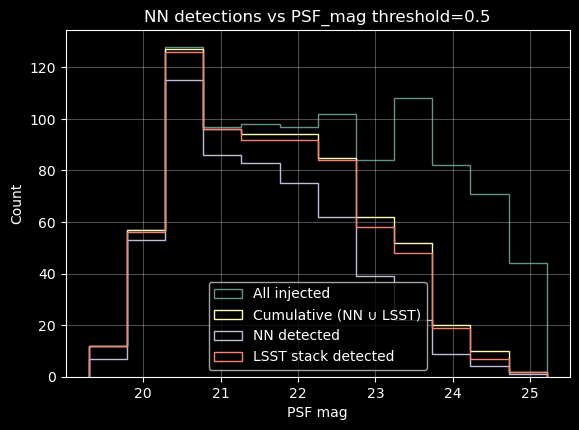

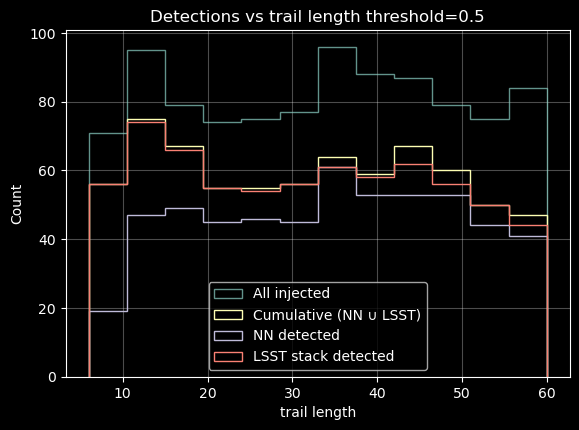

In [25]:
results_2, cat_2 = evaluate_model_on_catalog(test_catalog, p_2, gt_test, threshold=0.5)

## Idea 3

Two-phase loss schedule (BCE → Focal Tversky)

Phase 1: train with BCE (optionally BCE+Dice) for stability.

Phase 2: gradually blend in Focal Tversky: L = (1 - λ) * L_BCE + λ * L_FocalTversky, ramp λ from 0 to 1 over selected epochs. Optionally reduce learning rate at start of Phase 2.

In [26]:
model_3 = load_model(SAVE_PATH+"Last/idea3.pt")
p_3 = predict_tiles_to_full(test_h5, test_loader, model_3, tile=128)
model_3.to('cpu')
gc.collect()
torch.cuda.empty_cache()
print("Predictions shape:", p_3.shape)

Loaded model from: ../checkpoints/Experiments/Last/idea3.pt
Predictions shape: (50, 4000, 4072)


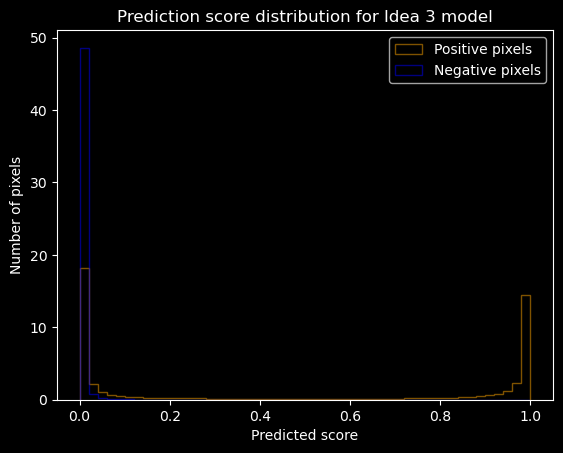

In [27]:
_ = plt.hist(p_3[gt_test>0.5].flatten(), bins=50, alpha=0.5, label="Positive pixels", histtype="step", density=True, color='orange')
_ = plt.hist(p_3[gt_test==0].flatten(), bins=50, alpha=0.5, label="Negative pixels", histtype="step", density=True, color='blue')
_ = plt.xlabel("Predicted score")
_ = plt.ylabel("Number of pixels")
_ = plt.legend()
_ = plt.title("Prediction score distribution for Idea 3 model")
plt.show()

Pixelwise Confusion Matrix @ thr=0.5
F1 Score: 0.4439, F2 Score: 0.4594
                 Predicted Negative  Predicted Positive
Actual Negative           812771760              640825
Actual Positive              522922              464493

Objectwise Confusion Matrix @ thr=0.5
F1 Score: 0.5404, F2 Score: 0.5515
                 Predicted Negative  Predicted Positive
Actual Negative                  -1                 500
Actual Positive                 432                 548


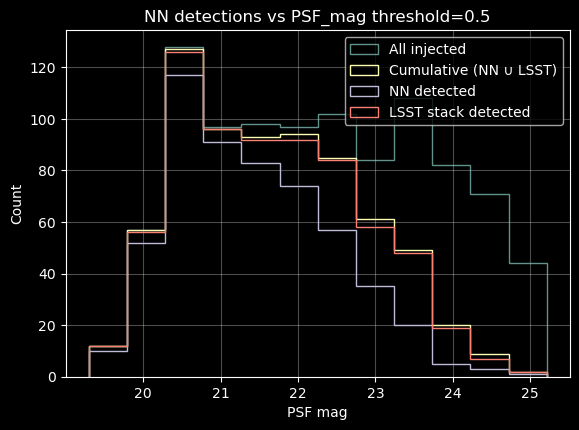

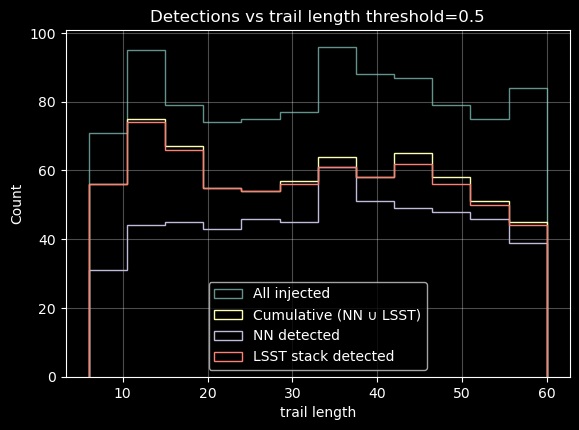

In [28]:
results_3, cat_3 = evaluate_model_on_catalog(test_catalog, p_3, gt_test, threshold=0.5)

Pixelwise Confusion Matrix @ thr=0.5
F1 Score: 0.4417, F2 Score: 0.4629
                 Predicted Negative  Predicted Positive
Actual Negative           812733960              678625
Actual Positive              515206              472209

Objectwise Confusion Matrix @ thr=0.5
F1 Score: 0.6564, F2 Score: 0.5839
                 Predicted Negative  Predicted Positive
Actual Negative                  -1                 111
Actual Positive                 447                 533


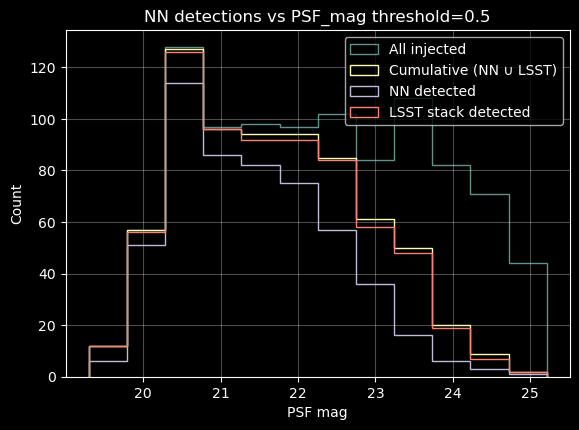

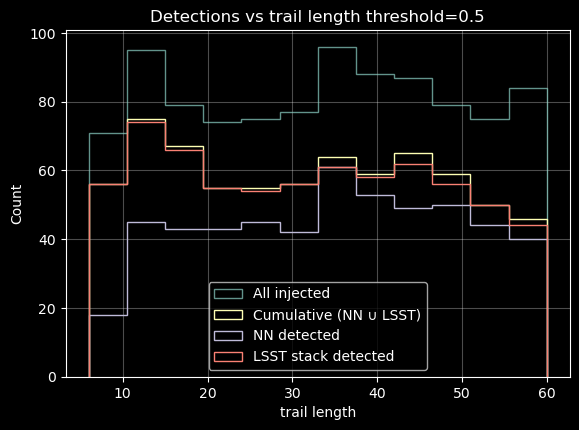

In [29]:
_ , _ = evaluate_model_on_catalog(test_catalog, (p_baseline + p_1 + p_2 + p_3) / 4, gt_test, threshold=0.5)